Optimization of Materials Datasets with GPytorch

In [1]:
import pandas as pd
import numpy as np
import random
import torch

import gpytorch
from gpytorch.likelihoods import GaussianLikelihood
from botorch.fit import fit_gpytorch_mll

from tqdm import trange

import matplotlib.pyplot as plt

plt.style.use('ggplot')

torch.set_default_dtype(torch.float64)
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    print("MPS device found, setting as device.")
else:
    print("MPS device not found.")


c:\Users\stan\miniconda3\envs\research\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MPS device not found.


Define a few helper functions

In [2]:
class TorchStandardScaler:
    def fit(self, x):
        x = x.clone()
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
    def transform(self, x):
        x = x.clone()
        x -= self.mean
        x /= (self.std + 1e-10)
        return x
    def fit_transform(self, x):
        x = x.clone()
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
        x -= self.mean
        x /= (self.std + 1e-10)
        return x
    def reverse(self, x):
        x = x.clone()
        x *= (self.std + 1e-10)
        x += self.mean
        return x

class TorchNormalizer:
    def fit(self, x):
        self.max = torch.max(x, dim=0).values
        self.min = torch.min(x, dim=0).values

    def transform(self, x):
        return (x.clone() - self.min) / (self.max - self.min)

    def fit_transform(self, x):
        self.max = torch.max(x, dim=0).values
        self.min = torch.min(x, dim=0).values
        return (x.clone() - self.min) / (self.max - self.min)

def set_seeds(seed=42):
    """set all library random seeds"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def UCB(pred, epsilon=2):
    return pred.mean + epsilon*pred.stddev

In [3]:
dataset = 'Crossed barrel'
df = pd.read_csv(f"datasets/{dataset}_dataset.csv")

# take the average of duplicate entries, not always a good idea
df = df.groupby(list(df.columns[:-1])).mean()
df = pd.DataFrame(df.reset_index())

# convert to torch tensors
N = len(df)
X_ = torch.tensor(df.iloc[:, :-1].values)
y_ = torch.tensor(df.iloc[:, -1].values)

# We are using prededfined candidates, so we can scale at the start
TorchStd = TorchStandardScaler()
TorchStd.fit(X_)

Construct a model in GPytorch 

In [4]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        super(GPModel, self).__init__(x_train, y_train, likelihood)

        # use a constant mean, learnable
        self.mean_module = gpytorch.means.ConstantMean()

        # use a scaled Matern kernel, learnable
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5,ard_num_dims=4))

    def forward(self, x):
        # forward pass of the model
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

Run an optimization campaign

In [5]:
op_budget = 100 # how many optimization iterations perform
n_initial = 10 # how many points to start with

set_seeds(120) # set seeds for all libraries

# sample n_initial points from X_ data pool
idx = torch.randperm(N)[:n_initial]
X = X_.clone()[idx]
y = y_.clone()[idx]

for trial in trange(op_budget):

    X = TorchStd.transform(X) # standardize data
    y = TorchStandardScaler().fit_transform(y) 

    # fit the model to current data pool
    likelihood = GaussianLikelihood(noise_prior=gpytorch.priors.HalfNormalPrior(0.01))
    gp = GPModel(X, y, likelihood)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)
    fit_gpytorch_mll(mll)

    # predict from candidate pool
    with torch.no_grad():
        pred = gp(TorchStd.transform(X_)) # predict values for all candidates
    
    acqf_vals = UCB(pred) # pass preds through acquisition function
    acqf_vals[idx] = -100 # don't select already sampled points
    idx = torch.cat([idx, acqf_vals.argmax().unsqueeze(0)]) # add best value to index

    X = X_[idx] # re-pull data with updated index pool
    y = y_[idx] # re-pull data with updated index pool

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\stan\miniconda3\envs\research\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
100%|██████████| 100/100 [00:07<00:00, 13.17it/s]


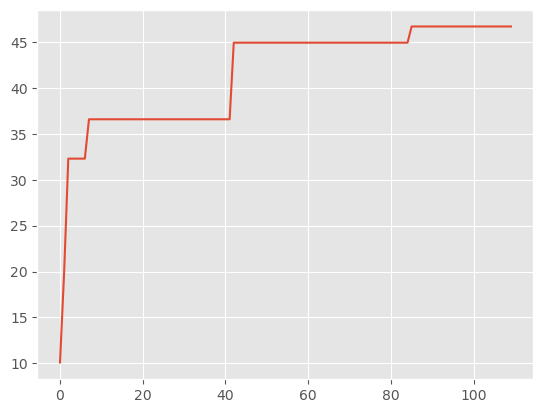

In [8]:
plt.plot(np.maximum.accumulate(y.detach().numpy()), label='True')